#Netlix data analysis

This project analyzes Netflix’s content library to uncover trends in genres, countries, and release years. Using data cleaning, visualization, and SQL queries, it provides insights into Netflix’s global content distribution and viewer preferences.


###Setup

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

# Settings for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load dataset
path = '/content/netflix_titles.csv'
df = pd.read_csv(path)
# Data obtained from https://www.kaggle.com/datasets/shivamb/netflix-shows

# Basic info
print("Shape:", df.shape)
df.head()

Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


###Clean data

In [14]:
df.isnull().sum().sort_values(ascending=False)

,0
director,2634
country,831
cast,825
date_added,10
rating,4
duration,3
show_id,0
type,0
title,0
release_year,0


In [15]:
# Convert date_added to datetime, handle invalid formats
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Fill missing text fields
df['country'] = df['country'].fillna('Unknown')
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')

# Fill rating with most common value
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

# Drop rows with no date_added
df = df.dropna(subset=['date_added']).copy()

# Add helper columns
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

#Data analysis

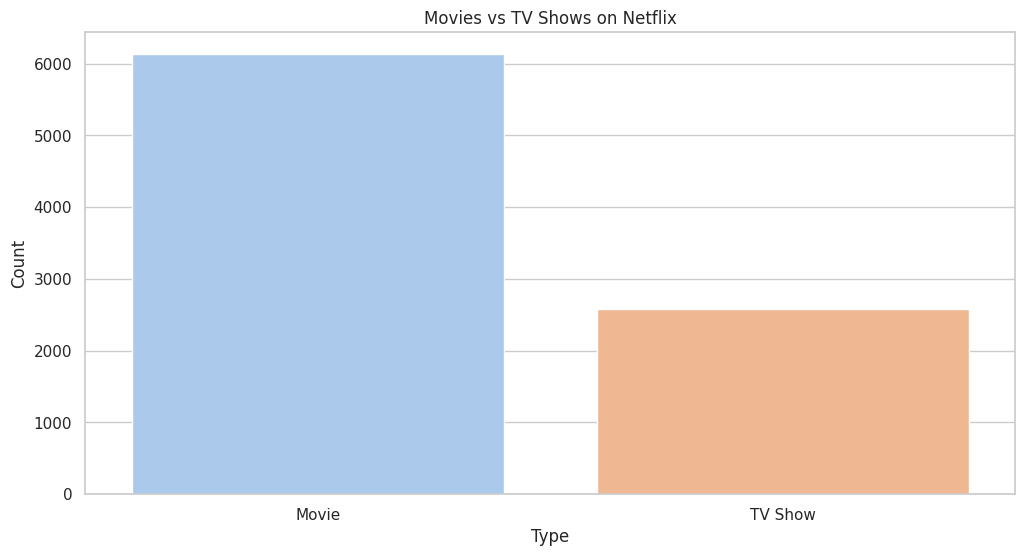

In [16]:
#Amount of Movies vs TV Shown on Netflix

sns.countplot(data=df, x='type', hue='type', palette='pastel', legend=False)
plt.title('Movies vs TV Shows on Netflix')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

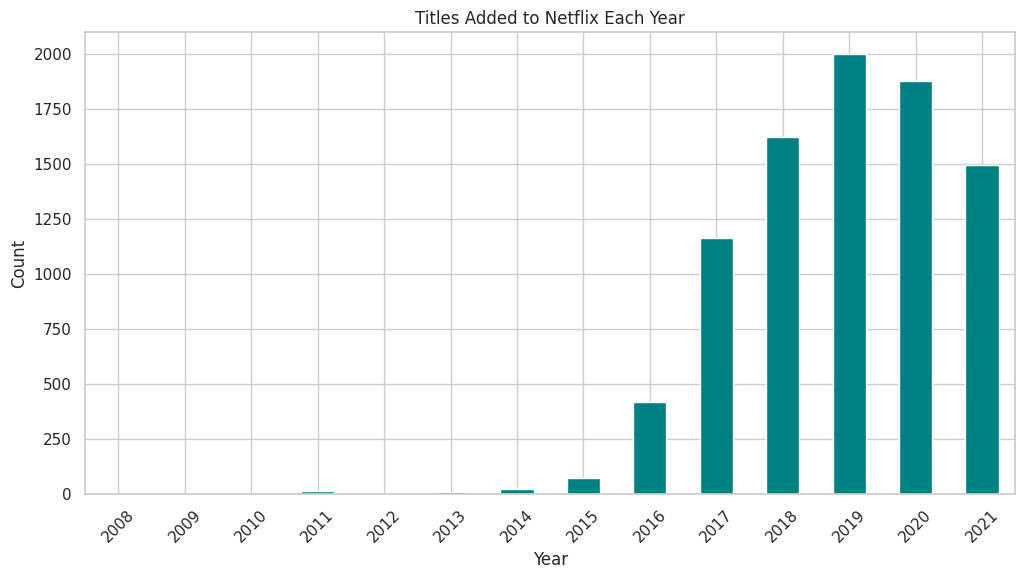

In [17]:
#Ttiles added to Netflix per year

df['year_added'].value_counts().sort_index().plot(kind='bar', color='teal')
plt.title("Titles Added to Netflix Each Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

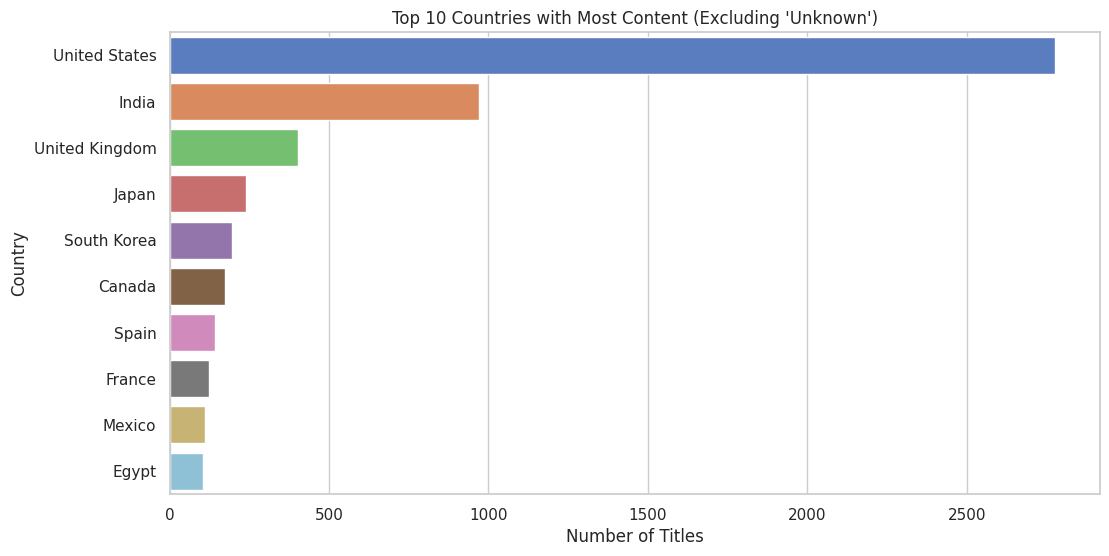

In [18]:
# Filter out 'Unknown' countries
filtered_df = df[df['country'] != 'Unknown']

# Get top 10 countries
top_countries_df = filtered_df['country'].value_counts().head(10).reset_index()
top_countries_df.columns = ['country', 'count']

# Plot
sns.barplot(data=top_countries_df, y='country', x='count', hue='country', palette='muted', legend=False)
plt.title("Top 10 Countries with Most Content (Excluding 'Unknown')")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.show()

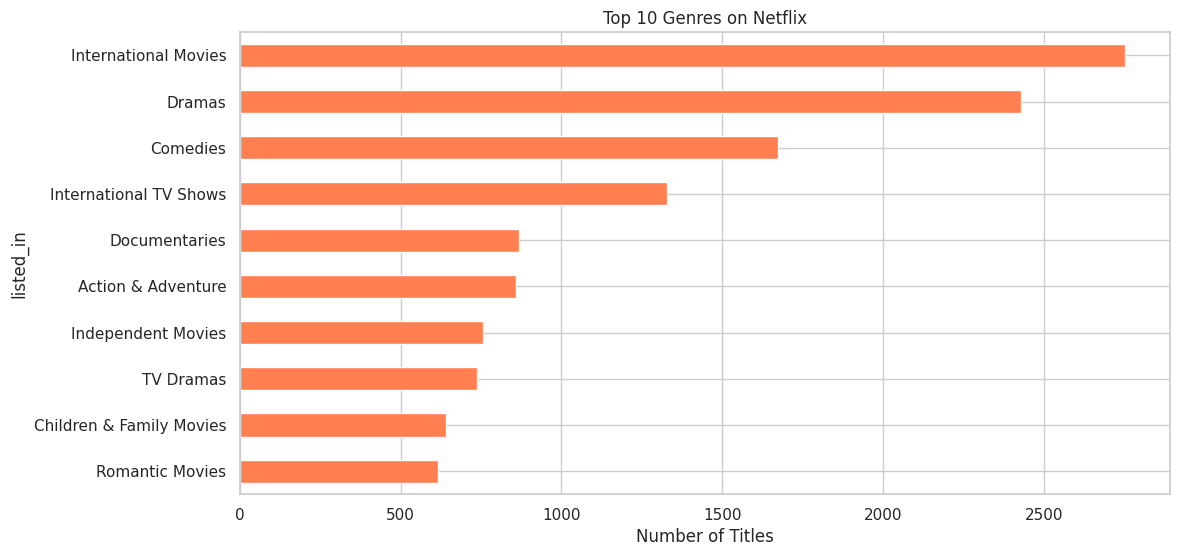

In [19]:
#Top genres on Netflix

df['listed_in'].str.split(', ').explode().value_counts().head(10).plot(kind='barh', color='coral')
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Number of Titles')
plt.gca().invert_yaxis()
plt.show()

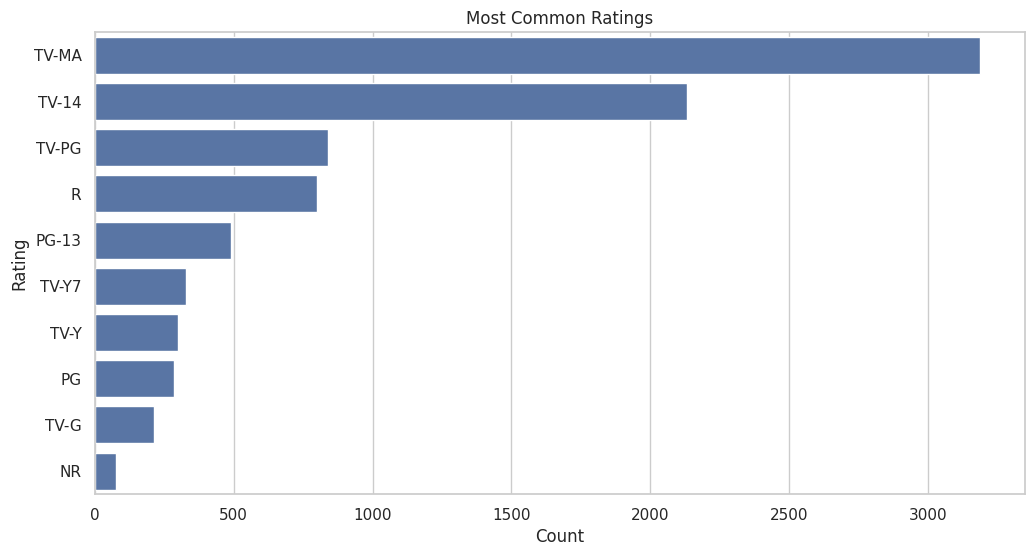

In [20]:
#Most common ratings on Netflix content

sns.countplot(data=df, y='rating', order=df['rating'].value_counts().index[:10])
plt.title("Most Common Ratings")
plt.xlabel("Count")
plt.ylabel("Rating")
plt.show()

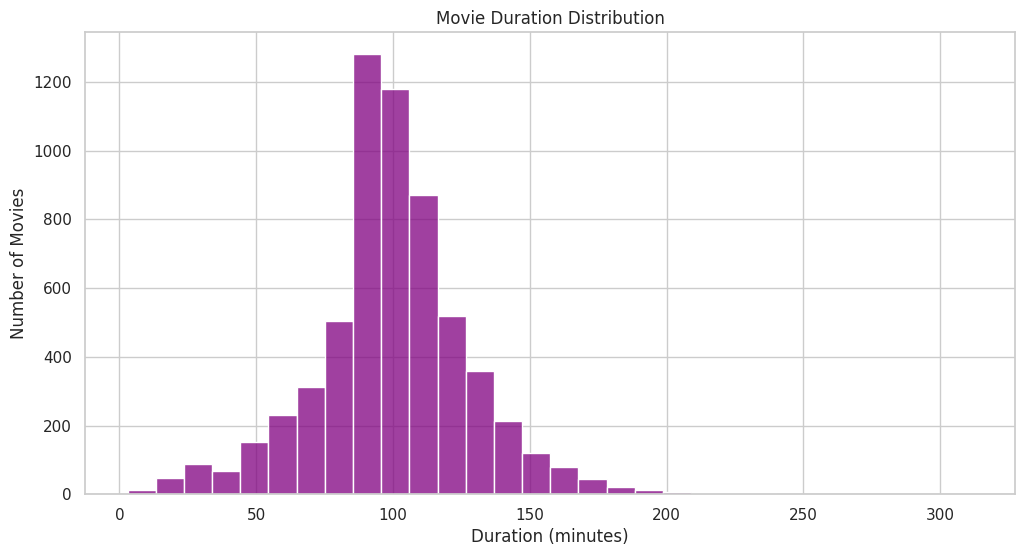

In [21]:
#Duration distribution of movies

movies = df[df['type'] == 'Movie'].copy()
movies['duration_minutes'] = movies['duration'].str.extract('(\d+)').astype(float)

sns.histplot(movies['duration_minutes'].dropna(), bins=30, color='purple')
plt.title("Movie Duration Distribution")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Movies")
plt.show()

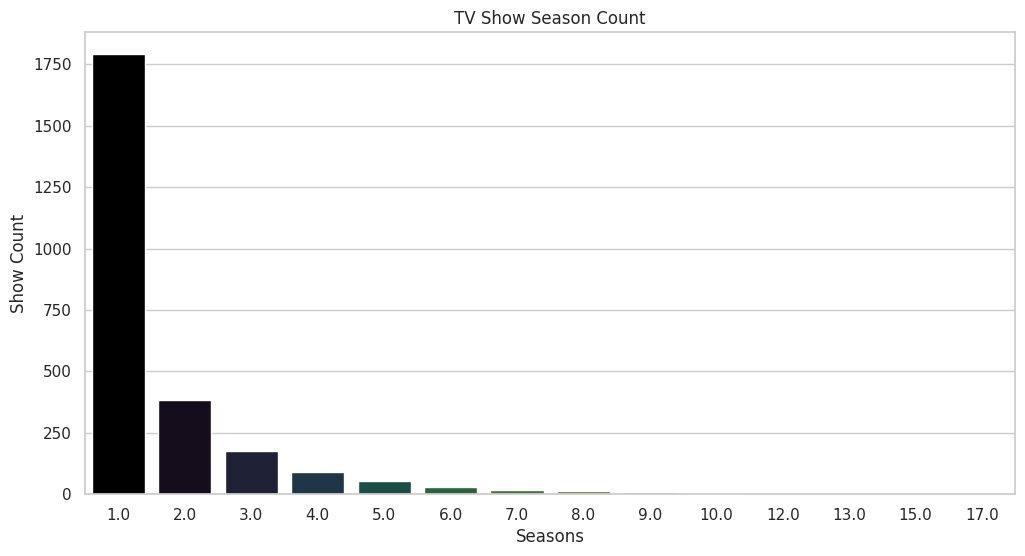

In [22]:
#Season count for Netflix's TV shows

tv_shows = df[df['type'] == 'TV Show'].copy()
tv_shows['seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(float)

sns.countplot(data=tv_shows, x='seasons', hue='seasons', palette='cubehelix', legend=False)
plt.title("TV Show Season Count")
plt.xlabel("Seasons")
plt.ylabel("Show Count")
plt.show()

#Data analysis with SQL

In [23]:
#Most common directors on Netflix

query = """
SELECT director, COUNT(*) AS num_titles
FROM df
WHERE director != 'Unknown' AND director IS NOT NULL
GROUP BY director
ORDER BY num_titles DESC
LIMIT 10
"""
duckdb.query(query).to_df()

,director,num_titles
0,Rajiv Chilaka,19
1,"Raúl Campos, Jan Suter",18
2,Suhas Kadav,16
3,Marcus Raboy,16
4,Jay Karas,14
5,Cathy Garcia-Molina,13
6,Jay Chapman,12
7,Martin Scorsese,12
8,Youssef Chahine,12
9,Steven Spielberg,11


In [24]:
#Most common ratings on Netflix

query = """
SELECT rating, COUNT(*) AS count
FROM df
GROUP BY rating
ORDER BY count DESC
"""
duckdb.query(query).to_df()

,rating,count
0,TV-MA,3187
1,TV-14,2133
2,TV-PG,838
3,R,799
4,PG-13,490
5,TV-Y7,330
6,TV-Y,300
7,PG,287
8,TV-G,212
9,NR,78


#Conclusions

* The majority of Netflix titles are movies, with over 6,000, while TV shows account for nearly 3,000.
* Content additions were relatively low from 2010 to 2015, began increasing in 2016, peaked in 2019, and declined slightly in 2020 and 2021.
* The United States has the highest number of titles, followed by India.
* The most common genre is International Movies, with Drama in second place.
* The most frequent content rating is TV-MA, applied to over 3,000 titles.
* The most typical movie duration is approximately 100 minutes.
* The vast majority of TV shows—over 1,750—consist of just one season.
* Rajiv Chilaka is the most featured director on the platform, with 19 titles.
